### Get and  dependencies for setting up YOLOv5

In [ ]:
# Get YOLOv5 file from this repo
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10597, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10597 (delta 2), reused 8 (delta 0), pack-reused 10587
Receiving objects: 100% (10597/10597), 10.74 MiB | 34.25 MiB/s, done.
Resolving deltas: 100% (7323/7323), done.


In [ ]:
# Install neccessary libararies
!pip install -r /content/yolov5/requirements.txt

     |████████████████████████████████| 596 kB 23.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Install neccesary libararies
import torch   # YOLOv5 works with torch rather than tensorflow
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

### TOY EXAMPLE ( WOULD NEED TO CHANGE SOME THINGS HERE TO MATCH OUR DATA WHEN WE START TO TAKE PROPER PICS )

In [ ]:
# Define the datapath ( We would change this to /content/mdp_symbolRecog )

%mkdir /content/Road_Sign_Dataset

In [ ]:
# Download the roadsign data (CAN DELETE/IGNORE THIS CELL LATER, IM JUST USING IT TO TEST THINGS OUT AND SEE THE FORMAT OF HOW THINGS ARE DONE )
!wget -O RoadSignDetectionDataset.zip "https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2"

--2022-01-21 01:01:45--  https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2
Resolving arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)... 13.32.207.208
Connecting to arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)|13.32.207.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229344361 (219M) [application/zip]
Saving to: ‘RoadSignDetectionDataset.zip’

RoadSignDetectionDa 100%[===================>] 218.72M  60.0MB/s    in 3.5s    

2022-01-21 01:01:48 (63.1 MB/s) - ‘RoadSignDetectionDataset.zip’ saved [229344361/229344361]



In [ ]:
# The road dataset is a small one, containing only 877 images in total
!unzip /content/RoadSignDetectionDataset.zip

Archive:  /content/RoadSignDetectionDataset.zip
   creating: annotations/
  inflating: __MACOSX/._annotations  
  inflating: annotations/road712.xml  
  inflating: __MACOSX/annotations/._road712.xml  
  inflating: annotations/road706.xml  
  inflating: __MACOSX/annotations/._road706.xml  
  inflating: annotations/road289.xml  
  inflating: __MACOSX/annotations/._road289.xml  
  inflating: annotations/road538.xml  
  inflating: __MACOSX/annotations/._road538.xml  
  inflating: annotations/road510.xml  
  inflating: __MACOSX/annotations/._road510.xml  
  inflating: annotations/road276.xml  
  inflating: __MACOSX/annotations/._road276.xml  
  inflating: annotations/road262.xml  
  inflating: __MACOSX/annotations/._road262.xml  
  inflating: annotations/road504.xml  
  inflating: __MACOSX/annotations/._road504.xml  
  inflating: annotations/road458.xml  
  inflating: __MACOSX/annotations/._road458.xml  
  inflating: annotations/road464.xml  
  inflating: __MACOSX/annotations/._road464.xml 

#### In this example the data wasnt in the required format for YOLOv5
ie. YOLOv5 needs annotations in txt format, for this dataset we do some conversions from .xml to txt, 

BUT we can skip this step for our model that we'll be creating, as we can just use ROBOFLOW to create the annotations and load them in here ( ROBOFLOW NEEDS US TO DO 1000 IMGS AT A TIME - limits of a free account )

Alternatively, we can download this application to do the annotations for us which gives it to us in the required format ( https://github.com/ivangrov/ModifiedOpenLabelling ) 









YOLOv5 FORMAT
- Each row is class x_center y_center width height format.
- Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
- Class numbers are zero-indexed (start from 0).

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict


print(extract_info_from_xml('annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


##### We now write a function to convert information contained in info_dict to YOLOv5 style annotations and write them to a txt file.

###### Define the classes we have ( in our case 31 classes/symbols ) in a dictionary

In [ ]:
# Dictionary that maps class names to IDs  # CHANGE THIS TO OUR CLASSES WHEN WE PUT IN OUT DATA 
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}


# Classficaion dictionary
# class_name_to_id_mapping = {'A': 0,'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
#  'H': 7, 'S': 8,'T': 9, 'U': 10, 'V': 11, 'W': 12, 'X': 13, 'Y': 14, 'Z': 15, 
#  '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24,
#  'UP': 25, 'DOWN': 26, 'RIGHT': 27, 'LEFT': 28, 'STOP': 29, 'MARKER': 30}

In [ ]:
##################################################################################################
# WE WONT NEED THIS PART AS OUR ANNOATONS ARE LIKELY TO ALREADY BE I TXT COS WERE GONNA HAND LABEL
##################################################################################################
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))


# Get the annotations
annotations = [os.path.join('/content/annotations', x) for x in os.listdir('/content/annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/annotations', x) for x in os.listdir('/content/annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:00<00:00, 7866.34it/s]


In [ ]:
# WHAT WE DO NEED TO DO IS DEFINE AN ARRAY ANNOATIONS WITH ALL THE .TXT FILE PATHS
#annotations = [PUT ALL THE .TXT FILE PATHS IN HERE, WE CAN PRINT THE ANNOATIONS ARRAY AS IN THE EXAMPLE AS A REFERENCE OF HOW IT SHOULD LOOK LIKE]

##### Display the imgs with bounding boxes overlaying them as a sanity check ( SHOULD RUN THIS ON OUR DATASET TOO AS A SANITY CHECK )

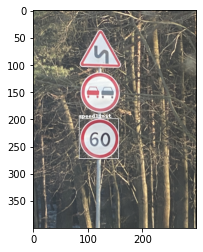

In [ ]:
# DISPLAY AN IMG TO SEE THE BOUNDING BOXES
# WE SHOULD DO THIS TOO

random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")   # THE EXAMPLE USED >PNG OUR WOULD BE JPG< SO JUST CHANGE PNG HERE TO JPG
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

### Split the Dataset into train, validation , and test sets 

Next we partition the dataset into

 train, 80% of the data

 validation, 10% of the data

 and test sets 10% of the data

You can change the split values according to your convenience. ( THIS RATIO SHOULD BE OK I THINK?)

In [ ]:
# Read images and annotations

# CHANGE THIS TO WHAT WE NEED LATER ON WHEN WE PUT IN OUR OWN DATA
image_path = "/content/images"
annotation_path = "/content/annotations"

images = [os.path.join(image_path, x) for x in os.listdir(image_path)]
annotations = [os.path.join(annotation_path, x) for x in os.listdir(annotation_path) if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
# Create seperate locations to store the data so that its more organized
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [ ]:
# Move the files to their respective folders.

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/images/train')
move_files_to_folder(val_images, '/content/images/val/')
move_files_to_folder(test_images, '/content/images/test')

move_files_to_folder(train_annotations, '/content/annotations/train')
move_files_to_folder(val_annotations, '/content/annotations/val')
move_files_to_folder(test_annotations, '/content/annotations/test')

In [ ]:
# Rename the annotations folder to labels, as this is where YOLO v5 expects the annotations to be located in.

#### Setup the YAML file


Data Config File

Details for the dataset you want to train your model on are defined by the data config YAML file. The following parameters have to be defined in a data config file:

train, test, and val: Locations of train, test, and validation images.

nc: Number of classes in the dataset.

names: Names of the classes in the dataset. The index of the classes in this list would be used as an identifier for the class names in the code.

Create a new file called road_sign_data.yaml and place it in the yolov5/data folder. Then populate it with the following.



train: /content/images/train/

val: /content/images/val/

test: /content/images/test/

###### number of classes
nc: 4

###### class names
names: ["trafficlight","stop", "speedlimit","crosswalk"]


YOLO v5 expects to find the training labels for the images in the folder whose name can be derived by replacing images with labels in the path to dataset images. For example, in the example above, YOLO v5 will look for train labels in ../content/labels/train/.

#### Hyperparameter Config File
The hyperparameter config file helps us define the hyperparameters for our neural network. We are going to use the default one, data/hyp.scratch.yaml. This is what it looks like.

In [ ]:
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials


lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)

# You can edit this file, save a new file, and specify it as an argument to the train script.

##### Custom Network Architecture [ I DONT THINK WE NEED THIS, SO CAN SKIP THIS STEP ]
YOLO v5 also allows you to define your own custom architecture and anchors if one of the pre-defined networks doesn't fit the bill for you. For this you will have to define a custom weights config file. For this example, we use the the yolov5s.yaml. This is what it looks like.

In [ ]:
# I DONT THINK WE NEED THIS, SO CAN SKIP THIS STEP

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

SyntaxError: ignored

In [ ]:
!python "/content/yolov5/train.py" --img 640 --cfg /content/yolov5/models/yolov5n.yaml --hyp /content/yolov5/data/hyps/hyp.scratch.yaml --batch 32 --epochs 30 --data /content/yolov5/data/road_sign_data.yaml --weights yolov5n.pt --workers 24 --name yolo_road_det

train: weights=yolov5n.pt, cfg=/content/yolov5/models/yolov5n.yaml, data=/content/yolov5/data/road_sign_data.yaml, hyp=/content/yolov5/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_road_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-203-g9bcc32a torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anch

#### Inference ( PREDICTION )
There are many ways to run inference using the detect.py file.

The source flag defines the source of our detector, which can be:

A single image

A folder of images

Video

Webcam

...and various other formats. We want to run it over our test images so we set the source flag to /content/Road_Sign_Dataset/images/test


The weights flag defines the path of the model which we want to run our detector with.

conf flag is the thresholding objectness confidence.

name flag defines where the detections are stored. We set this flag to 
yolo_road_det; therefore, the detections would be stored in runs/detect/yolo_road_det/.



In [ ]:
!python /content/yolov5/detect.py --source /content/images/test --weights /content/yolov5/runs/train/yolo_road_det2/weights/best.pt --conf 0.25 --name yolo_road_det

detect: weights=['/content/yolov5/runs/train/yolo_road_det2/weights/best.pt'], source=/content/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-203-g9bcc32a torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 1764577 parameters, 0 gradients, 4.2 GFLOPs
image 1/88 /content/images/test/road100.png: 640x640 Done. (0.009s)
image 2/88 /content/images/test/road113.png: 448x640 1 speedlimit, Done. (0.018s)
image 3/88 /content/images/test/road129.png: 448x640 1 trafficlight, 1 crosswalk, Done. (0.008s)
image 4/88 /content/images/test/road140.png: 448x640 1 crosswalk, Done. (0.0

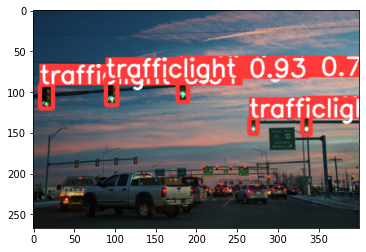

In [ ]:
detections_dir = "/content/yolov5/runs/detect/yolo_road_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

###### Apart from a folder of images, there are other sources we can use for our detector as well. The command syntax for doing so is described by the following.

python detect.py --source 0  # webcam
                            file.jpg  # image 
                            file.mp4  # video
                            path/  # directory
                            path/*.jpg  # glob
                            rtsp://170.93.143.139/rtplive/470011e600ef003a004ee33696235daa  # rtsp stream
                            rtmp://192.168.1.105/live/test  # rtmp stream
                            http://112.50.243.8/PLTV/88888888/224/3221225900/1.m3u8  # http stream

###### Computing the mAP on the test dataset
We can use the  test  file to compute the mAP on our test set. To perform the evaluation on our test set, we set the task flag to test. We set the name to yolo_det. Things like plots of various curves (F1, AP, Precision curves etc) can be found in the folder runs/test/yolo_road_det. The script calculates for us the Average Precision for each class, as well as mean Average Precision.

In [ ]:
#!python test.py --weights runs/train/yolo_road_det/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

python3: can't open file 'test.py': [Errno 2] No such file or directory
